
# Air Pollution Forecasting


## THE MISSION

The story behind the dataset is how to apply LSTM architecture to understand and apply multiple variables together to contribute more accuracy towards forecasting.

## THE CONTENT

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. 

**The complete feature list in the raw data is as follows:**

**year :** year of data in this row

**month:** month of data in this row

**day:** day of data in this row


**hour :** hour of data in this row

**pm2.5 :** PM2.5 concentration

**DEWP:** Dew Point

**TEMP:** Temperature

**PRES:** Pressure

**Iws:** Cumulated wind speed

**Is:** Cumulated hours of snow

**Ir:** Cumulated hours of rain

## Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import os

## Reading the dataset

In [2]:
data = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv")
test_data = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv")
data.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


## Basic Statistics

In [3]:
data.shape

(43800, 9)

In [4]:
data.describe(include='all')

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
count,43800,43800.000000,43800.000000,43800.000000,43800.000000,43800,43800.000000,43800.000000,43800.000000
unique,43800,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN
top,2010-01-02 00:00:00,NaN,NaN,NaN,NaN,SE,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,15290,NaN,NaN,NaN
mean,NaN,94.013516,1.828516,12.459041,1016.447306,NaN,23.894307,0.052763,0.195023
std,NaN,92.252276,14.429326,12.193384,10.271411,NaN,50.022729,0.760582,1.416247
min,NaN,0.000000,-40.000000,-19.000000,991.000000,NaN,0.450000,0.000000,0.000000
25%,NaN,24.000000,-10.000000,2.000000,1008.000000,NaN,1.790000,0.000000,0.000000
50%,NaN,68.000000,2.000000,14.000000,1016.000000,NaN,5.370000,0.000000,0.000000
75%,NaN,132.250000,15.000000,23.000000,1025.000000,NaN,21.910000,0.000000,0.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


There are no null values - *we can go ahead with our data preprocessing*

## Data Preprocessing

In [6]:
unique_values = data['wnd_dir'].unique()
print(unique_values)

['SE' 'cv' 'NW' 'NE']


In [7]:
mapping = {value: idx for idx, value in enumerate(unique_values)}
print(mapping)

{'SE': 0, 'cv': 1, 'NW': 2, 'NE': 3}


In [8]:
data['wnd_dir'] = data['wnd_dir'].map(mapping)

In [9]:
data.head(4)

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,0,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,0,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,0,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,0,5.36,1,0


## Scaling the data

In [10]:
# Convert the 'date' column to datetime if it's not already
data['date'] = pd.to_datetime(data['date'])

# Extract relevant features from the 'date' column
data['hour'] = data['date'].dt.hour
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data = data.drop(columns=['date'])

In [11]:
# Scale numeric columns
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [12]:
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,hour,day_of_week,month,year
0,129.0,-16,-4.0,1020.0,0,1.79,0,0,0,5,1,2010
1,148.0,-15,-4.0,1020.0,0,2.68,0,0,1,5,1,2010
2,159.0,-11,-5.0,1021.0,0,3.57,0,0,2,5,1,2010
3,181.0,-7,-5.0,1022.0,0,5.36,1,0,3,5,1,2010
4,138.0,-7,-5.0,1022.0,0,6.25,2,0,4,5,1,2010


## **Framing the Forecasting Problem:** Converting the time-series data into a supervised learning problem.

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense

# Define the number of time steps (e.g., 12 time steps look back)
n_steps = 12

# Assuming 'data' is your dataframe and 'pollution' is the target
def create_supervised_data(data, n_steps):
    X, y = [], []
    
    for i in range(len(data) - n_steps):
        X.append(data.iloc[i:i+n_steps].drop(columns=['pollution']).values)
        y.append(data.iloc[i+n_steps]['pollution'])
    
    return np.array(X), np.array(y)

# Apply the function to create sequences
X, y = create_supervised_data(data, n_steps)

# Check shapes
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# Split into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check shapes of the split data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

# Convert data to float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Ensure that y_train and y_test are 1D arrays
print(f'y_train shape after conversion: {y_train.shape}')
print(f'y_test shape after conversion: {y_test.shape}')

X shape: (43788, 12, 11)
y shape: (43788,)
X_train shape: (35030, 12, 11)
y_train shape: (35030,)
X_test shape: (8758, 12, 11)
y_test shape: (8758,)
y_train shape after conversion: (35030,)
y_test shape after conversion: (8758,)


## Defining the model

In [14]:
# Define the BiLSTM model
model = Sequential()

# Adding BiLSTM layer with 50 units
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(12, X_train.shape[2])))  # Match input shape with X_train

# Adding output layer (1 unit for predicting pollution)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 100)                 │          24,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,901 (97.27 KB)

 Trainable params: 24,901 (97.27 KB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [15]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 8113.3198 - val_loss: 7715.6855
Epoch 2/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7173.7212 - val_loss: 7124.1523
Epoch 3/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7174.8628 - val_loss: 7186.2212
Epoch 4/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 6610.5049 - val_loss: 6244.5190
Epoch 5/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 6172.0483 - val_loss: 6374.9863
Epoch 6/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 6372.2515 - val_loss: 6320.9009
Epoch 7/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 5775.6709 - val_loss: 5866.4150
Epoch 8/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 5820.9233 - val_loss: 6009.3301
Epoch 9/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 5418.5352 - val_loss: 5828.4761
Epoch 10/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 5465.8491 - val_loss: 5673.0015


In [16]:
y_pred = model.predict(X_test)

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


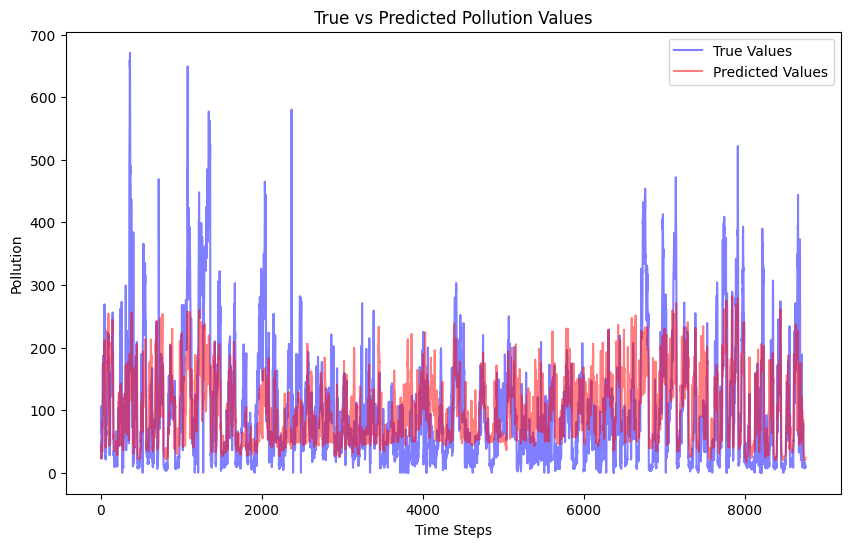

In [17]:
# Plot the true vs predicted values with transparency
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values', color='blue', alpha=0.5)
plt.plot(y_pred, label='Predicted Values', color='red', alpha=0.5)

plt.title('True vs Predicted Pollution Values')
plt.xlabel('Time Steps')
plt.ylabel('Pollution')
plt.legend()
plt.show()